## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch

## Generate Data

In [2]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.random(num_samples)
y = f_x + eps

In [3]:
x1 = torch.tensor(x1, dtype=torch.float32).reshape(-1, 1)
x1 = torch.hstack((x1, torch.ones_like(x1)))
y = torch.tensor(y, dtype=torch.float32)
theta = torch.randn(x1.shape[1], requires_grad=True)

print("The shape of x1 is: ", x1.shape)
print("The shape of y is: ", y.shape)
print("The shape of theta is: ", theta.shape)

The shape of x1 is:  torch.Size([40, 2])
The shape of y is:  torch.Size([40])
The shape of theta is:  torch.Size([2])


### Question 1

In [4]:
y_pred = x1@theta
loss = torch.nn.MSELoss()(y_pred, y)
print("Gradient before backward pass: ", theta.grad)
loss.backward()
print("Gradient after backward pass: ", theta.grad)
true_gradient = theta.grad.detach().clone()

Gradient before backward pass:  None
Gradient after backward pass:  tensor([ -0.5374, -10.2545])


In [5]:
gradient = []
theta.grad.zero_()
for i in range(len(x1)):
    y_pred_i = x1@theta
    loss_s = torch.nn.MSELoss()(y_pred_i[i], y[i])
    loss_s.backward(retain_graph=True)
    gradient.append(theta.grad.detach().clone())
    theta.grad.zero_()

### Question 2

In [6]:
gradient = torch.stack(gradient)
gradient = gradient.mean(dim=0)
print("Gradient using stochastic method: ", gradient)
print("Gradient after backward pass: ", true_gradient)

Gradient using stochastic method:  tensor([ -0.5374, -10.2545])
Gradient after backward pass:  tensor([ -0.5374, -10.2545])


In [7]:
x_ = x1.clone().numpy()
y_ = y.clone().numpy()
optimum_theta = np.linalg.inv(x_.T@x_)@x_.T@y_
print("Optimum theta: ", optimum_theta)

Optimum theta:  [3.0529928 4.467065 ]


### Question 3

In [8]:
def model(x, theta):
    return x@theta
loss_fn = torch.nn.MSELoss()


In [65]:
def full_batch_gd(x1:torch.tensor,y:torch.tensor,lr:float, epochs:int, converge = True):
    '''
    Performs the gradient descent using the full batch method

    Input:
    x1: torch.Tensor: The input features
    y: torch.Tensor: The target variable
    theta: torch.Tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs

    Returns:
    theta: torch.Tensor: The updated parameters
    '''
    theta = torch.rand(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    if not converge:
        for epoch in range(epochs):
            y_pred = model(x1, theta)
            loss = loss_fn(y_pred, y)
            loss.backward()

            # Update parameters
            with torch.no_grad():
                theta -= lr*theta.grad

            # Save history
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())

            # Zero gradients
            theta.grad.zero_()
    else:
        epoch=0
        while (converge):
            y_pred = model(x1, theta)
            loss = loss_fn(y_pred, y)
            loss.backward()

            # Update parameters
            with torch.no_grad():
                theta -= lr*theta.grad

            # Save history
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())
            if np.linalg.norm(theta.detach().numpy()-optimum_theta)<1e-3:
                converge = False
            
            # Zero gradients
            theta.grad.zero_()
            epoch+=1

    return theta_hist, loss_hist, epoch


In [64]:
def stochastic_gradient_descent(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int, converge=True):
    '''
    Performs the gradient descent using the stochastic method

    Input:
    x1: torch.Tensor: The input features
    y: torch.Tensor: The target variable
    theta: torch.Tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs

    Returns:
    theta: torch.Tensor: The updated parameters
    '''
    theta = torch.rand(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    if not converge:
        for epoch in range(epochs):
            for i in range(len(x1)):
                Y_pred = model(x1, theta)
                loss = loss_fn(Y_pred[i], y[i])
                
                loss.backward(retain_graph=True)
                with torch.no_grad():
                    theta -= lr*theta.grad
                theta.grad.zero_()
                theta_hist.append(theta.detach().clone())
                loss_hist.append(loss.item())
    else:
        epoch=0
        while (converge):
            for i in range(len(x1)):
                Y_pred = model(x1, theta)
                loss = loss_fn(Y_pred[i], y[i])
                
                loss.backward(retain_graph=True)
                with torch.no_grad():
                    theta -= lr*theta.grad
                theta.grad.zero_()
                theta_hist.append(theta.detach().clone())
                loss_hist.append(loss.item())
                if np.linalg.norm(theta.detach().numpy()-optimum_theta)<1e-3:
                    converge = False
            epoch+=1
    return theta_hist, loss_hist, epoch
            

In [63]:
def mini_batch_gradient_descent(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int, batch_size:int, converge=True):
    '''
    Performs the gradient descent using the mini batch method

    Input:
    x1: torch.tensor: The input features
    y: torch.tensor: The target variable
    theta: torch.tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs
    batch_size: int: The size of the batch

    Returns:
    theta: torch.tensor: The updated parameters
    '''
    theta = torch.rand(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    if not converge:
        for epoch in range(epochs):
            for i in range(0, len(x1), batch_size):
                x_batch = x1[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = model(x_batch, theta)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                with torch.no_grad():
                    theta -= lr*theta.grad
                theta.grad.zero_()
                theta_hist.append(theta.detach().clone())
                loss_hist.append(loss.item())
    else:
        epoch=0
        while (converge):
            for i in range(0, len(x1), batch_size):
                x_batch = x1[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = model(x_batch, theta)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                with torch.no_grad():
                    theta -= lr*theta.grad
                theta.grad.zero_()
                theta_hist.append(theta.detach().clone())
                loss_hist.append(loss.item())
                if np.linalg.norm(theta.detach().numpy()-optimum_theta)<1e-3:
                    converge = False
            epoch+=1
    return theta_hist, loss_hist, epoch

In [66]:
epochs = 15
batch_size = 5 
lr = 0.01
fbgd_iter=0
sgd_iter=0
mbgd_iter=0
fb_gd_epochs = 0
sgd_epochs = 0
mbgd_epochs = 0
for i in range(10):
    fb_gd = full_batch_gd(x1, y, lr, epochs)
    sgd = stochastic_gradient_descent(x1, y,  lr, epochs)
    mb_gd = mini_batch_gradient_descent(x1, y, lr, epochs, batch_size)
    fbgd_iter+=len(fb_gd[0])
    sgd_iter+=len(sgd[0])
    mbgd_iter+=len(mb_gd[0])
    fb_gd_epochs+=fb_gd[2]
    sgd_epochs+=sgd[2]
    mbgd_epochs+=mb_gd[2]
print("Full batch gradient descent iterations: ", fbgd_iter/10, "Number of epochs: ", fb_gd_epochs/10)
print("Stochastic gradient descent iterations: ", sgd_iter/10, "Number of epochs: ", sgd_epochs/10)
print("Mini batch gradient descent iterations: ", mbgd_iter/10, "Number of epochs: ", mbgd_epochs/10)

Full batch gradient descent iterations:  1307.8 Number of epochs:  1306.8
Stochastic gradient descent iterations:  965.0 Number of epochs:  24.1
Mini batch gradient descent iterations:  1235.4 Number of epochs:  154.3


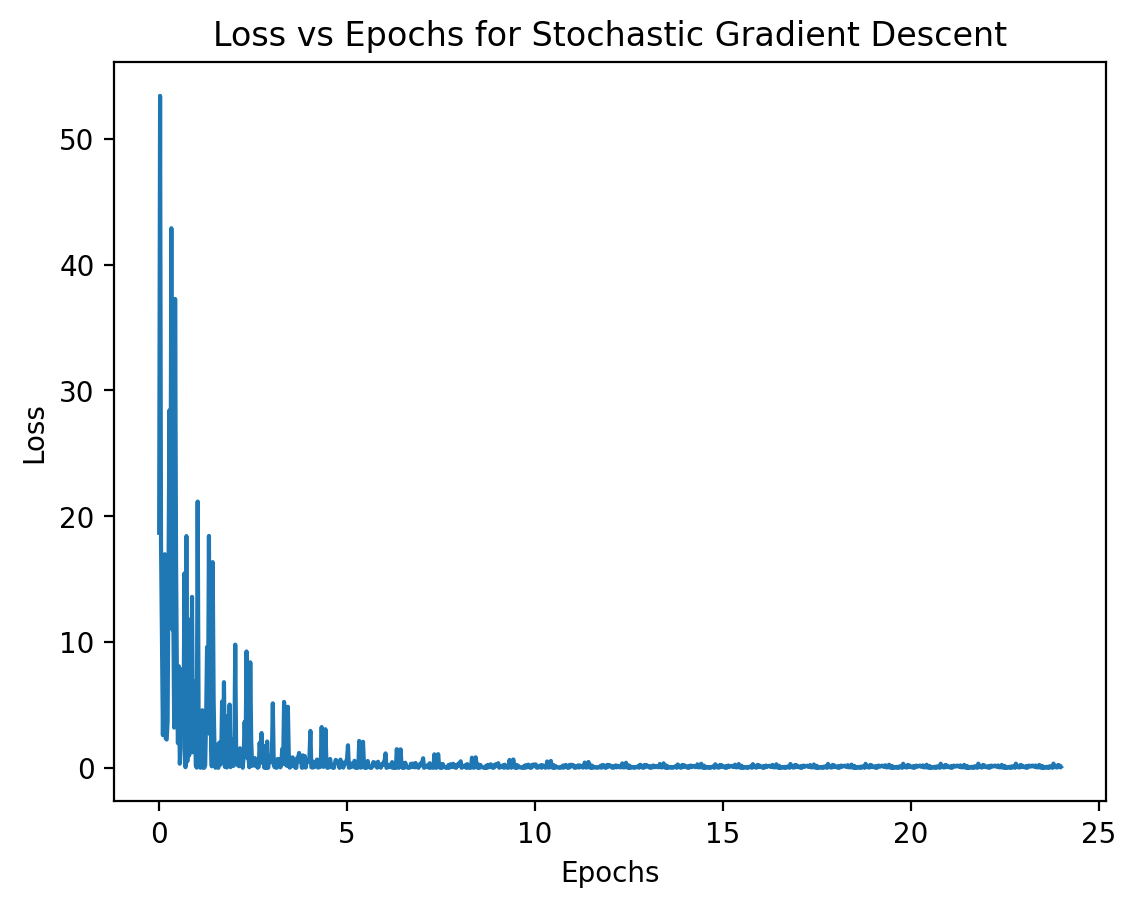

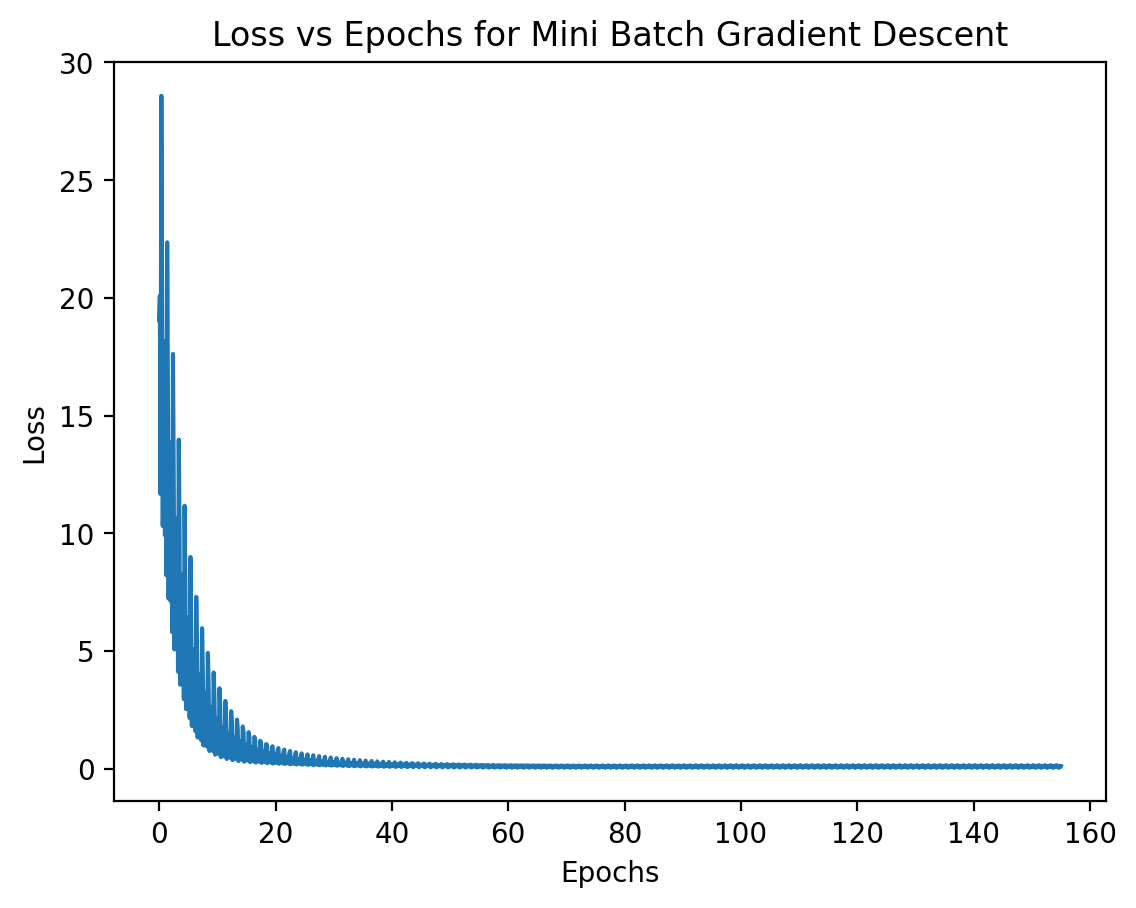

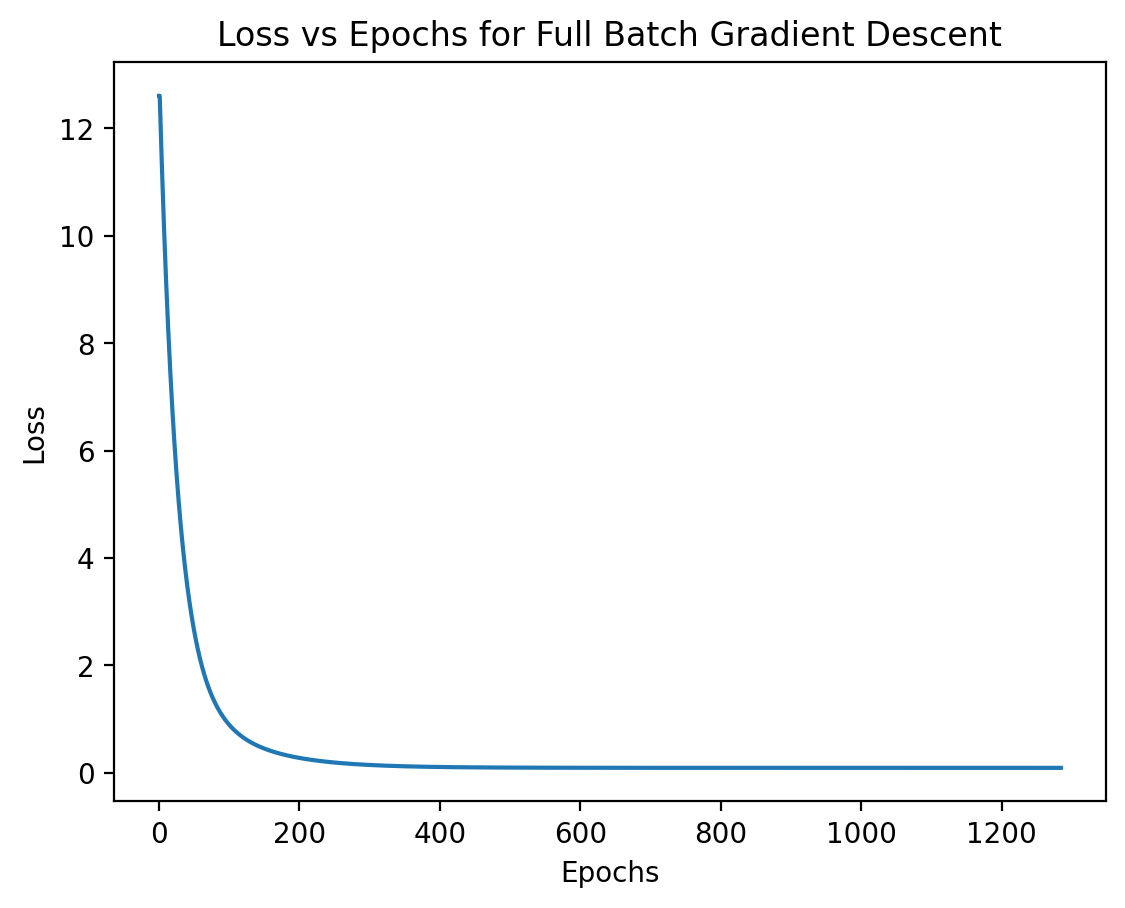

In [67]:
x_sgd = np.linspace(0, sgd[2], len(sgd[1]))
x_mb = np.linspace(0, mb_gd[2], len(mb_gd[1]))
x_fb = np.linspace(0, fb_gd[2], len(fb_gd[1]))
plt.plot(x_sgd, sgd[1], label='Stochastic')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Stochastic Gradient Descent')
plt.show()
plt.plot(x_mb, mb_gd[1], label='Mini Batch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Mini Batch Gradient Descent')
plt.show()
plt.plot(x_fb, fb_gd[1], label='Full Batch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Full Batch Gradient Descent')
plt.show()



The vanilla gradient descent takes more epochs to converge because thetas are update only after the whole epoch is completed whereas in the other two methods, thetas are updated many times in a single epoch.

(16, 2) (16,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_1784\570150671.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


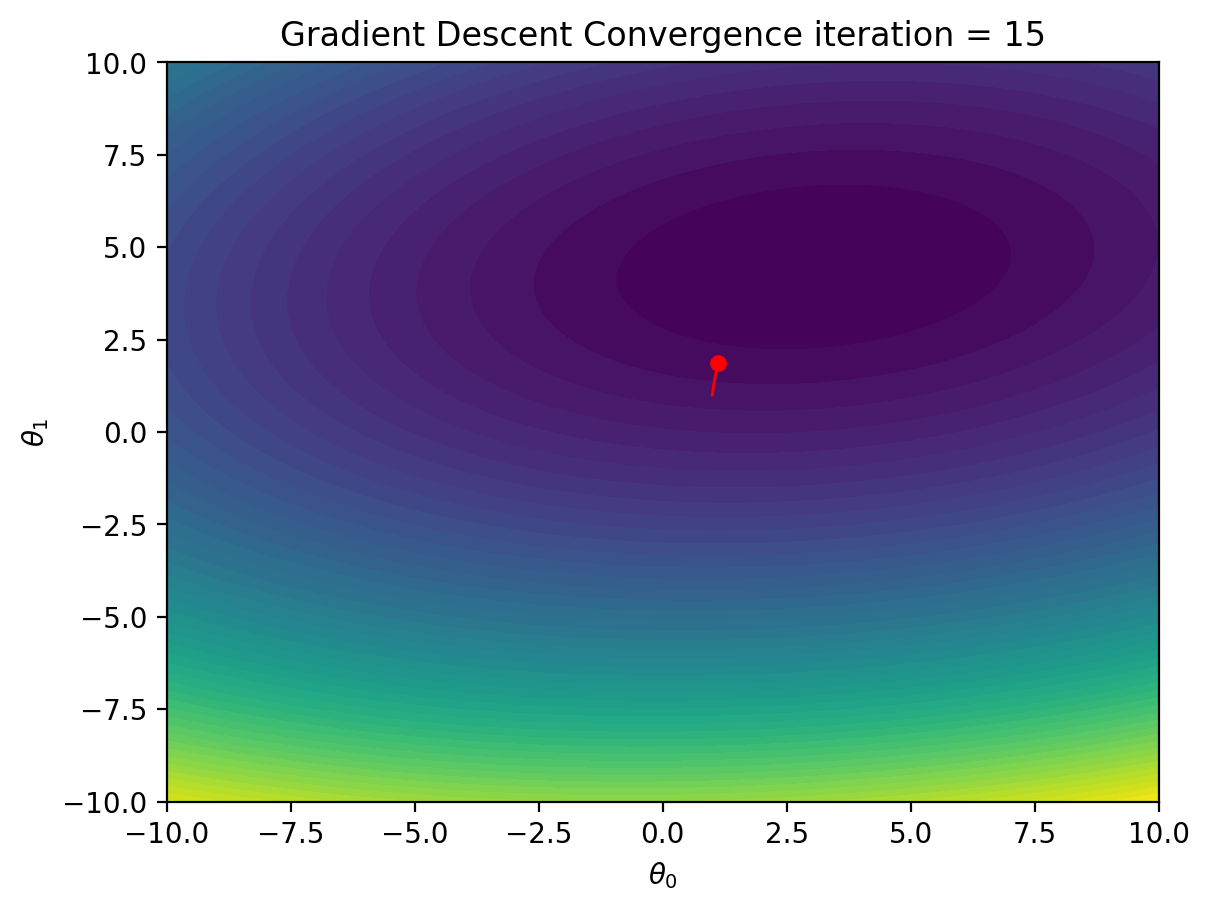

In [25]:
fb_gd = full_batch_gd(x1, y, lr, epochs, False)
theta_vals=np.array(fb_gd[0])
loss_vals = np.array(fb_gd[1])
print(theta_vals.shape, loss_vals.shape)

theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

fig, ax = plt.subplots()


contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence')


point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line


def update(frame):    
    if frame < len(theta_vals):
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')  
    return point, line

ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

ani.save('Full_Batch.gif', writer='pillow', fps=2)

plt.show()


(601, 2) (601,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_1784\4195959229.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


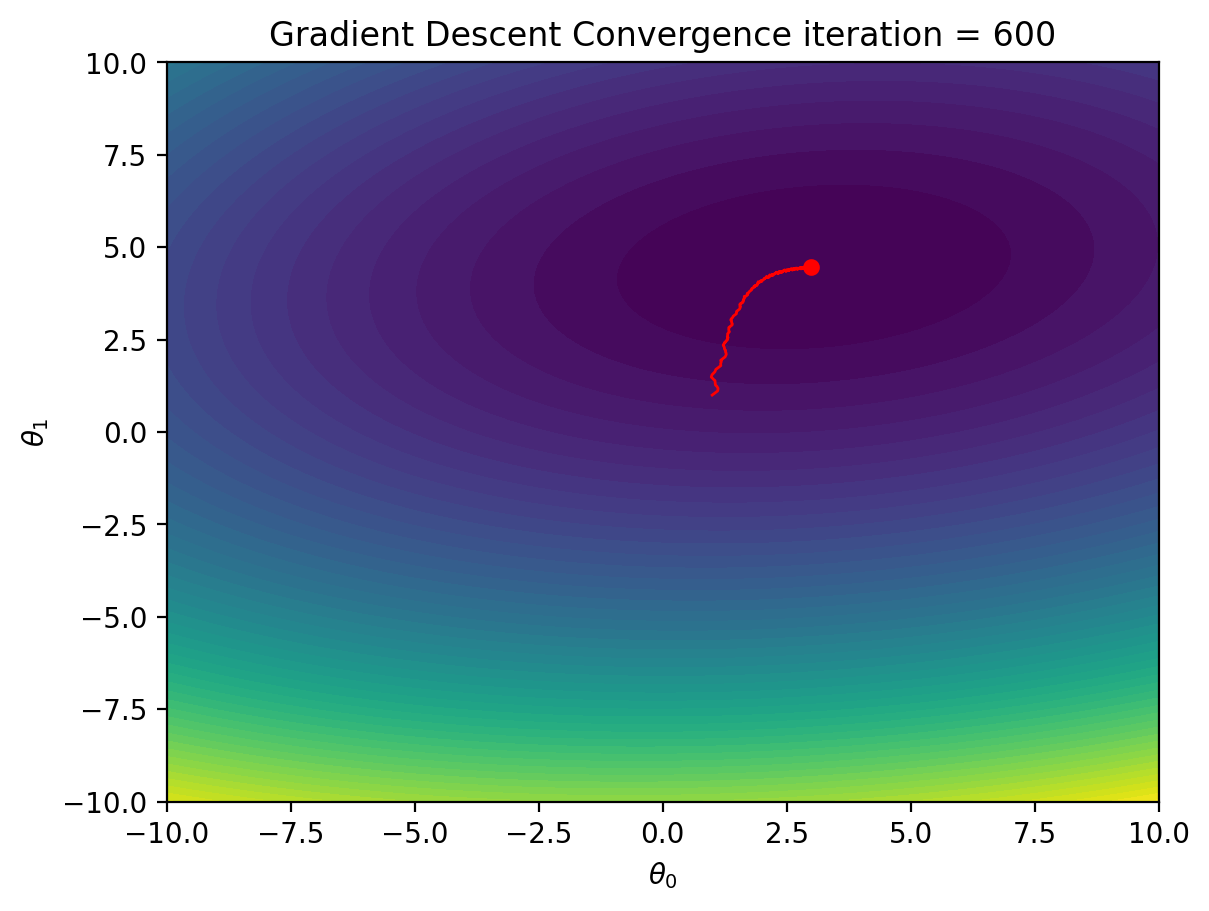

In [26]:
sgd = stochastic_gradient_descent(x1, y, lr, epochs, False)
theta_vals=np.array(sgd[0])
loss_vals = np.array(sgd[1])
print(theta_vals.shape, loss_vals.shape)

theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

fig, ax = plt.subplots()


contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')


point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line

def update(frame):    
    if frame < len(theta_vals):
 
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        

        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')
    return point, line

ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

ani.save('Stochastic_Gradient_Descent.gif', writer='pillow', fps=2)

plt.show()


(121, 2) (121,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_1784\3083186710.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


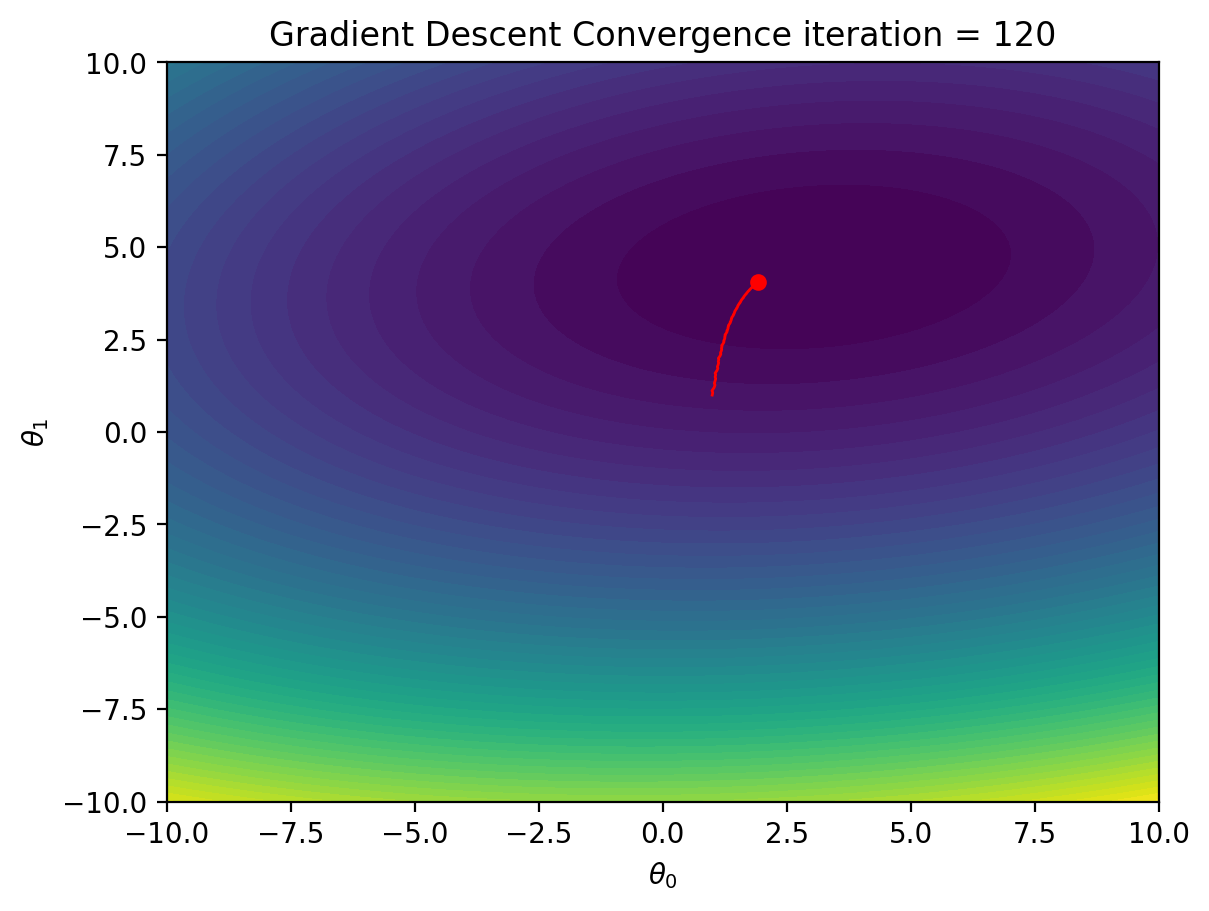

In [27]:
mb_gd = mini_batch_gradient_descent(x1, y, lr, epochs, batch_size, False)
theta_vals=np.array(mb_gd[0])
loss_vals = np.array(mb_gd[1])
print(theta_vals.shape, loss_vals.shape)

theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)


loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

fig, ax = plt.subplots()


contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')

point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line


def update(frame):    
    if frame < len(theta_vals):

        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
  
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')
    return point, line


ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

ani.save('Mini_Batch_Gradient_Descent.gif', writer='pillow', fps=2)

plt.show()


### Question 4

In [69]:
def gradient_descent_with_momentum(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int, momentum:float, converge=True):
    '''
    This function implements the gradient descent algorithm with momentum

    Input:
    x1: torch.tensor: The input features
    y: torch.tensor: The target variable
    lr: float: The learning rate
    epochs: int: The number of epochs
    momentum: float: The momentum value

    Returns:
    theta_hist: list: The history of the parameters
    loss_hist: list: The history of the loss values
    '''
    theta = torch.rand(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist, v_hist = [], [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    v = torch.zeros_like(theta)
    if not converge:
        for epoch in range(epochs):
            y_pred = model(x1, theta)
            loss = loss_fn(y_pred, y)
            loss.backward()
            with torch.no_grad():
                v = momentum * v + (1 - momentum) * theta.grad
                theta -= v
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())
            v_hist.append(v)
            theta.grad.zero_()
    else:
        epoch=0
        while (converge):
            y_pred = model(x1, theta)
            loss = loss_fn(y_pred, y)
            loss.backward()
            with torch.no_grad():
                v = momentum * v + (1 - momentum) * theta.grad
                theta -= v
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())
            v_hist.append(v)
            if np.linalg.norm(theta.detach().numpy()-optimum_theta)<1e-3:
                converge = False
            theta.grad.zero_()
            epoch+=1
    return theta_hist, loss_hist, epoch, v

In [70]:
gdm_iter = 0
fbgd_iter = 0
for i in range(10):
    gd_m = gradient_descent_with_momentum(x1, y, lr, epochs, 0.9)
    # print("Number of iterations for Gradient Descent with Momentum: ", len(gd_m[0]))
    gdm_iter+=len(gd_m[0])
    fb_gd = full_batch_gd(x1, y, lr, epochs)
    # print("Number of iterations for Full Batch Gradient Descent: ", len(fb_gd[0]))
    # print(fbgd_iter)
    fbgd_iter+=len(fb_gd[0])


In [71]:
print("Average number of iterations for Gradient Descent with Momentum: ", gdm_iter/10)
print("Average number of iterations for Full Batch Gradient Descent: ", fbgd_iter/10)

Average number of iterations for Gradient Descent with Momentum:  133.0
Average number of iterations for Full Batch Gradient Descent:  1300.7


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_1784\971263273.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


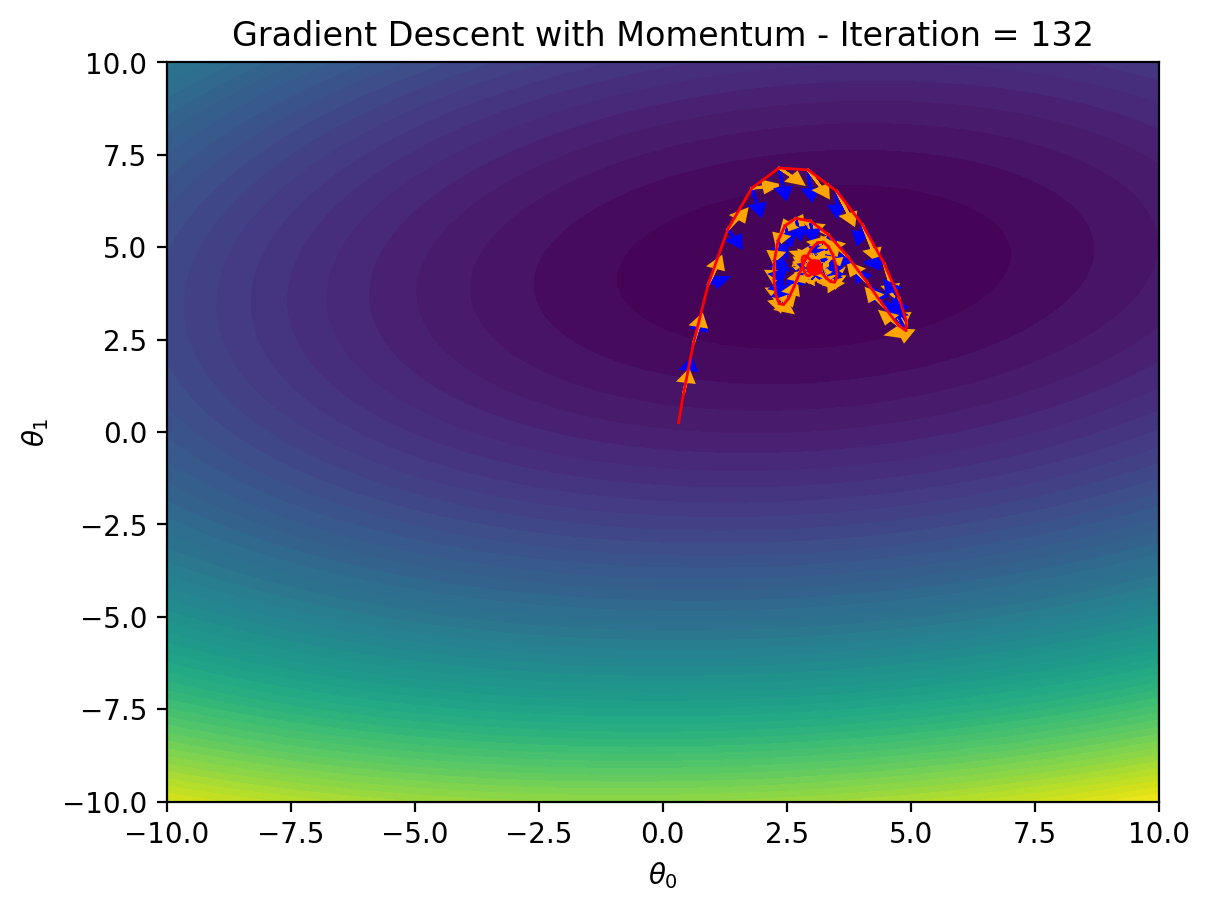

In [93]:
theta_vals=np.array(gd_m[0])
loss_vals = np.array(gd_m[1])

theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()


fig, ax = plt.subplots()

contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')

point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)


def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line


momentum_coefficient = 0.9
velocity = np.zeros(2)  


def update(frame):
    global velocity  

    if frame < len(theta_vals):
        theta_0, theta_1 = theta_vals[frame]

        point.set_data(theta_0, theta_1)
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])

        if frame > 0:
            theta_tensor = torch.tensor([theta_0, theta_1], dtype=torch.float32, requires_grad=True)
            y_pred = model(x1, theta_tensor)
            # print(y_pred)
            loss = loss_fn(y_pred, y)

            if theta_tensor.grad is not None:
                theta_tensor.grad.zero_()

            loss.backward()
            
            velocity = momentum_coefficient * velocity + (1 - momentum_coefficient) * theta_tensor.grad.numpy().flatten()

            ax.arrow(theta_0, theta_1, - theta_tensor.grad.numpy()[0] * 0.1, - theta_tensor.grad.numpy()[1] * 0.1, 
                     head_width=0.3, head_length=0.3, fc='blue', ec='blue')
            
            ax.arrow(theta_0, theta_1, -velocity[0] * 0.5, -velocity[1] * 0.5, 
                     head_width=0.3, head_length=0.3, fc='orange', ec='orange')

    
    ax.set_title(f'Gradient Descent with Momentum - Iteration = {frame}')
    return point, line


ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)
ani.save('Gradient Descent with Momentum.gif', writer='pillow', fps=2)
plt.show()


### Observations:
The thetas bounces off many times even after reaching a good value because of the momentum and velocity. Still, it is able to converge faster as velocity is helping to updates theta in a rapid manner.